In [1]:
import numpy as np
import os
import math
import datetime
import pandas as pd
import statistics
import random

from IPython.display import SVG
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from keras.utils import np_utils
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, BaseLogger, History, Callback

from keras.utils.visualize_util import model_to_dot
from sklearn.metrics import log_loss

import utils            # data load and cache
import architectures    # models

Using TensorFlow backend.


# Data Import

In [2]:
# 1 - gray, 3 - rgb
color_type = 3 

# input image dimensions
img_rows, img_cols = (32, 32)

train_data, train_target, driver_id, unique_drivers = utils.read_and_normalize_train_data(img_rows, img_cols, color_type)
test_data, test_id = utils.read_and_normalize_test_data(img_rows, img_cols, color_type)

Restore train from cache!
Train shape: (22424, 3, 32, 32)
22424 train samples
Restore test from cache!
Test shape: (79726, 3, 32, 32)
79726 test samples


# Cross validation

In [3]:
class LossHistory(Callback):
    def __init__(self, patience):
        super(Callback, self).__init__()
        self.patience = patience

    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.loss = np.inf
        self.val_loss = np.inf

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
    
    def on_train_end(self, logs={}):
        self.val_loss = min(self.val_losses[-(self.patience+2):])
        self.loss = self.losses[-(self.patience+2):][self.val_losses[-(self.patience+2):].index(self.val_loss)]

model_id = '160520'

nfolds = 5
nb_epoch = 20
batch_size = 32

random_state = 51
patience = 1
b_predit_test = True

np.random.seed(random_state)
model = architectures.create_model(img_rows, img_cols, color_type)

yfull_test = []
loss = []
val_loss = []

kf = KFold(len(unique_drivers), n_folds=nfolds, shuffle=True, random_state=random_state)

for num_fold, (train_drivers, test_drivers) in enumerate(kf):

    unique_list_train = [unique_drivers[i] for i in train_drivers]
    unique_list_valid = [unique_drivers[i] for i in test_drivers]
    X_train, Y_train, train_index = utils.copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
    X_valid, Y_valid, test_index = utils.copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)

    num_fold += 1
    print('Start KFold {}/{}'.format(num_fold, nfolds))
#     print('Train: {}, Validation: {} ({:.1%})'.format(len(X_train), len(X_valid), len(X_valid)/(len(X_valid)+len(X_train))))
    print('Train drivers: ', unique_list_train)
    print('Test drivers: ', unique_list_valid)
    print()
    
    kfold_weights_path = os.path.join('..', 'data', 'cache', 'weights_kfold_' + str(model_id) + '_' + str(num_fold) + '.h5')

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
        ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
        LossHistory(patience=patience)
    ]
    
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          shuffle=True, verbose=1, validation_data=(X_valid, Y_valid),
          callbacks=callbacks)
    
    loss.append(callbacks[2].loss)
    val_loss.append(callbacks[2].val_loss)
    
    # load best model to make predictions
    if os.path.isfile(kfold_weights_path):
        model.load_weights(kfold_weights_path)
        
    # Store test predictions
    if b_predit_test:
        print('Prediction for the test dataset') 
        yfull_test.append(model.predict(test_data, batch_size=16*batch_size, verbose=1))
        print()

Start KFold 1/5
Train drivers:  ['p002', 'p014', 'p015', 'p016', 'p021', 'p022', 'p035', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p064', 'p066', 'p075', 'p081']
Test drivers:  ['p012', 'p024', 'p026', 'p039', 'p061', 'p072']

Train on 17373 samples, validate on 5051 samples
Epoch 1/20
17373/17373 [==============================] - 153s - loss: 1.7606 - val_loss: 1.8140
Epoch 2/20
17373/17373 [==============================] - 153s - loss: 1.0278 - val_loss: 1.5873
Epoch 3/20
17373/17373 [==============================] - 152s - loss: 0.7382 - val_loss: 1.3862
Epoch 4/20
17373/17373 [==============================] - 152s - loss: 0.5616 - val_loss: 1.3517
Epoch 5/20
17373/17373 [==============================] - 151s - loss: 0.4568 - val_loss: 1.5093
Epoch 6/20
17373/17373 [==============================] - 150s - loss: 0.3830 - val_loss: 1.4456
Prediction for the test dataset
79726/79726 [==============================] - 270s   

Start KFold 2/5
Train d

# Results

In [4]:
print('Train loss: {:.4f}; Validation loss: {:.4f}'.format(np.mean(loss), np.mean(val_loss)))
print()
print('Model Summary')
model.summary()

Train loss: 0.4384; Validation loss: 0.5321

Model Summary
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_1 (Convolution2D)    (None, 16, 32, 32)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 16, 32, 32)  2320        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)      (None, 16, 16, 16)  0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)                (None, 16, 16, 16)  0           maxpooling2d_1[0][0]             
________________________________

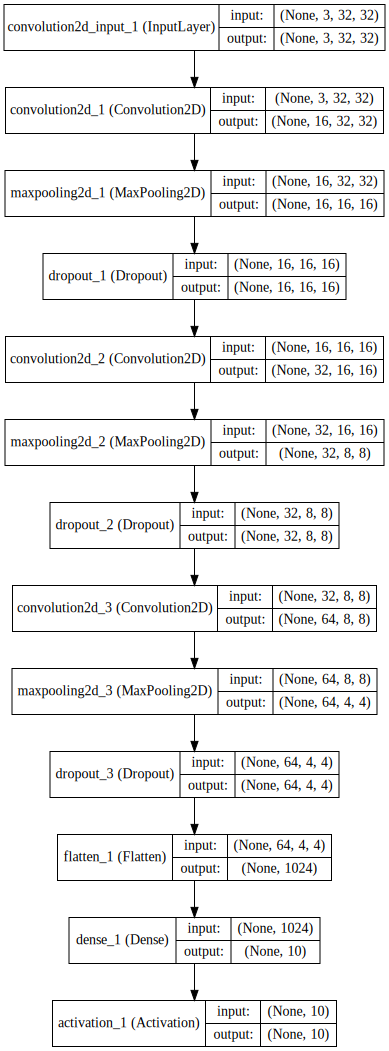

In [5]:
SVG(model_to_dot(model, show_shapes=True).create(format='svg'))

# Scoring and submission

In [5]:
info_string = 'id_' + str(model_id)\
                + '_loss_' + str(round(np.mean(val_loss), 4)) \
                + '_r_' + str(img_rows) \
                + '_c_' + str(img_cols) \
                + '_folds_' + str(nfolds)
print(info_string)

if b_predit_test:
    test_res = utils.merge_several_folds_mean(yfull_test)
    utils.create_submission(test_res, test_id, info_string)

id_160520_loss_0.5321_r_32_c_32_folds_5
